Importing Necessary Libraries

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from scipy.stats import norm  
from sklearn.preprocessing import StandardScaler 
from scipy import stats 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

import gc
import string
color = sns.color_palette()

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Train and Test Data

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Dataset_NLP/drugsComTrain_raw.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Dataset_NLP/drugsComTest_raw.csv")

In [ ]:
df_train.shape, df_test.shape

((161297, 7), (53766, 7))

In [ ]:
total_data = pd.concat([df_train, df_test])
total_data.shape

(215063, 7)

In [ ]:
total_data.describe()

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


In [ ]:
# checking if the data contains any NULL values

total_data.isnull().sum()

uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

Removing Redundant and Null Data

In [ ]:
# Dropping the data points with null values as it's very much less than 5% of the whole dataset
total_data = total_data.dropna(how = 'any', axis = 0)

print ("The shape of the dataset after null values removal :", total_data.shape)

The shape of the dataset after null values removal : (213869, 7)


Sorting Data Based Upon Unique ID

In [ ]:
# Sorting the dataframe
total_data.sort_values(['uniqueID'], ascending = True, inplace = True)
total_data.reset_index(drop = True, inplace = True)
total_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,27-Oct-15,11
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,26-Oct-15,12
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4
5,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1,24-Oct-15,3
6,7,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5,22-Oct-15,6
7,8,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Im 19 and have been having heavy and painful ...",5,21-Oct-15,2
8,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,21-Oct-15,5
9,10,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 years old and I got shot in Augus...",7,20-Oct-15,2


Unique Conditions In Dataset

In [ ]:
# Total unique conditions in the dataset
print (total_data['condition'].nunique(), "\n")

print ("some of the conditions are : ", total_data['condition'].unique()[11:20])

916 

some of the conditions are :  ['Depression' 'Narcolepsy' 'Allergic Rhinitis' 'Interstitial Cystitis'
 'Bladder Infection' 'Heart Attack' 'High Blood Pressure' 'Angina'
 'Rheumatoid Arthritis']


In [ ]:
# top 10 drugs with rating equals 9
total_data.loc[total_data['rating'] == 9, :]['drugName'].value_counts().head(10)

Levonorgestrel                        797
Etonogestrel                          526
Ethinyl estradiol / norethindrone     483
Phentermine                           437
Sertraline                            408
Escitalopram                          407
Ethinyl estradiol / norgestimate      406
Nexplanon                             348
Ethinyl estradiol / levonorgestrel    319
Lexapro                               300
Name: drugName, dtype: int64

Data Containing Useful Count Equals to Zero

In [ ]:
total_data.loc[total_data.usefulCount == 0, 'drugName'].value_counts()

Etonogestrel                         590
Levonorgestrel                       473
Ethinyl estradiol / norethindrone    371
Implanon                             327
Ethinyl estradiol / norgestimate     252
                                    ... 
Transderm-Scop                         1
Glimepiride / pioglitazone             1
Estazolam                              1
Vusion                                 1
Menthol                                1
Name: drugName, Length: 1487, dtype: int64

###Data Visualization

Visualization Of The Number Of Drugs Per Condition

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

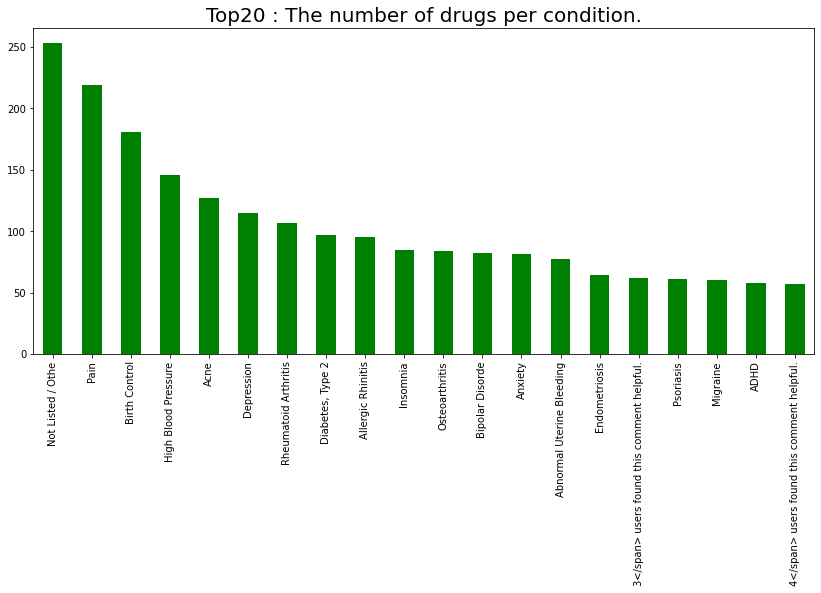

In [ ]:
condition_dn = total_data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

Visualization Of The Number Of Drugs With 1/10 Rating

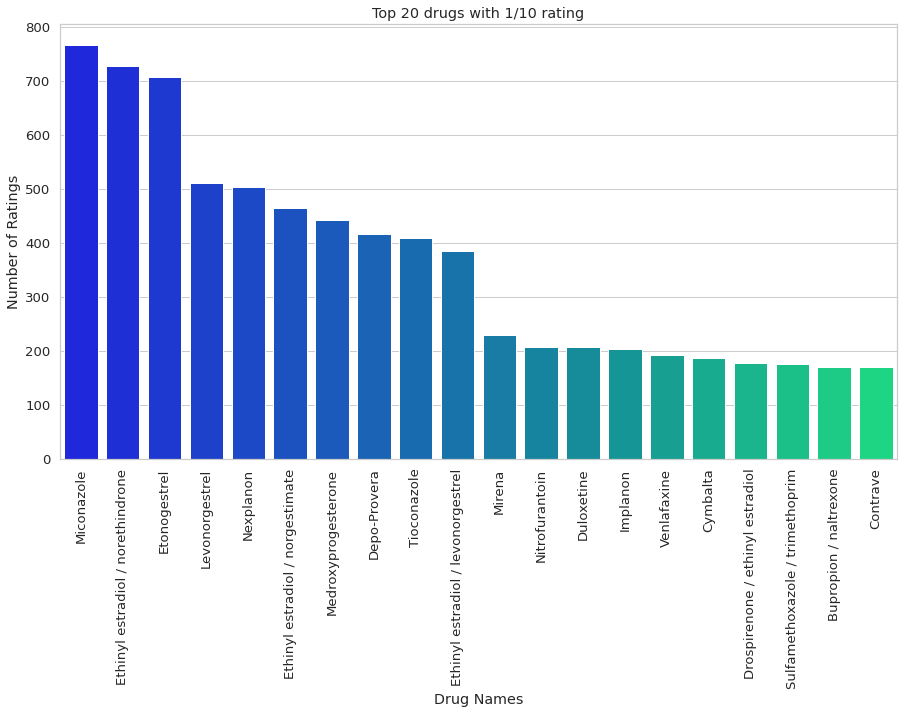

In [ ]:
# This barplot shows the Top 20 drugs with the 1/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(total_data.loc[total_data.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set(title = 'Top 20 drugs with 1/10 rating', ylabel = 'Number of Ratings', xlabel = "Drug Names")

plt.setp(sns_rating.get_xticklabels(), rotation=90);

### Word cloud of the reviews 

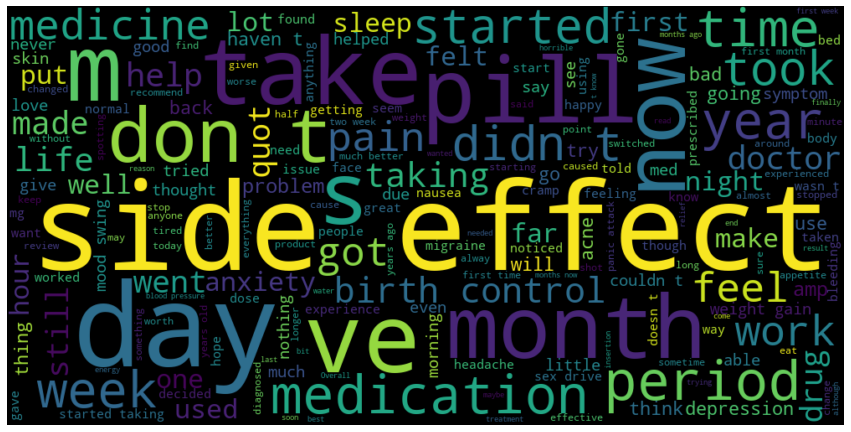

In [ ]:
from wordcloud import WordCloud, STOPWORDS

df_review = total_data['review']
k1 = (' '.join(df_review))

wordcloud = WordCloud(width = 1000, height = 500).generate(k1)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

###Data Pre-Processing

Removing Null Values

In [ ]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)
total_data = total_data.dropna(axis=0)

In [ ]:
total_data.isna().value_counts()

uniqueID  drugName  condition  review  rating  date   usefulCount
False     False     False      False   False   False  False          213869
dtype: int64

Feature Engineering

In [ ]:
# feature engineering 
# let's make a new column review sentiment 

total_data.loc[(total_data['rating'] >= 5), 'Review_Sentiment'] = 1
total_data.loc[(total_data['rating'] < 5), 'Review_Sentiment'] = 0

total_data['Review_Sentiment'].value_counts()

1.0    160613
0.0     53256
Name: Review_Sentiment, dtype: int64

Pie chart to represent the sentiments of the patients

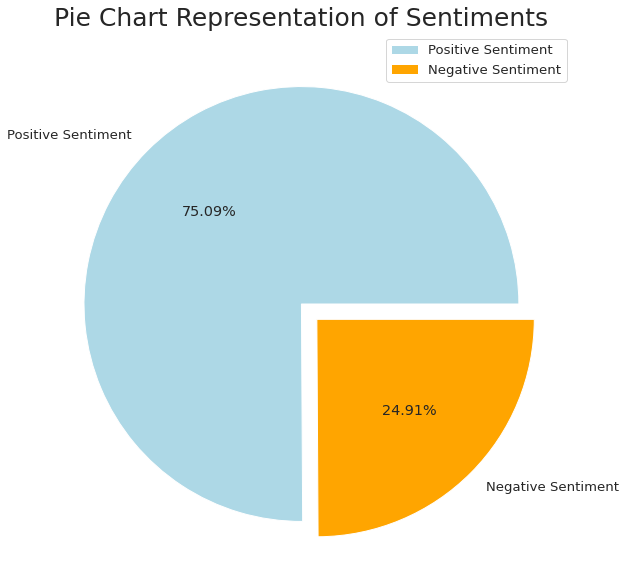

In [ ]:
size = [161491, 53572]
colors = ['lightblue', 'orange']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize = 25)
plt.legend()
plt.show()

Word Cloud Of Negative Reviews

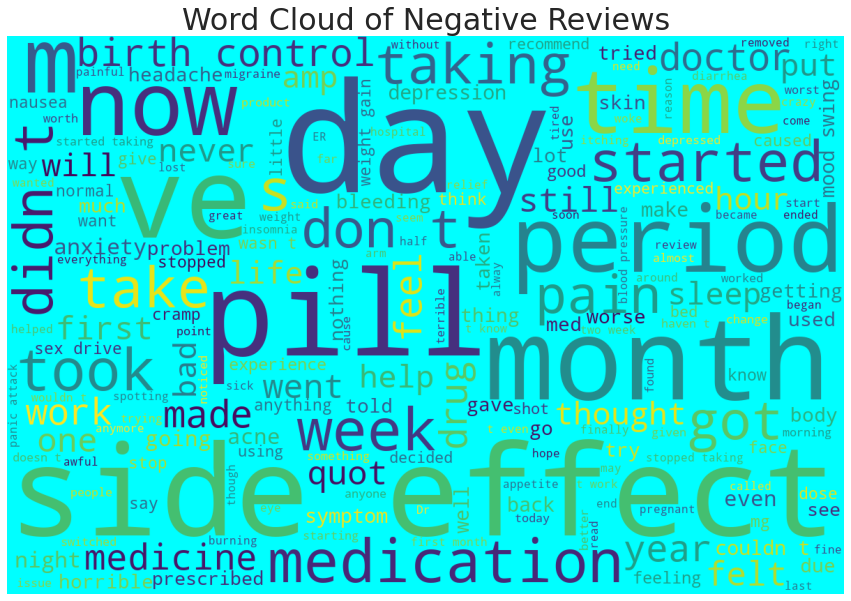

In [ ]:
negative_sentiments = " ".join([text for text in total_data['review'][total_data['Review_Sentiment'] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'cyan', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Data Cleaning

In [ ]:
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [ ]:
total_data['review_clean'] = review_clean(total_data['review'])

In [ ]:
total_data['review_clean'][0]

'been on the depo injection since january 2015 had bleeding but it stopped after a while when i had another injection in june i didnt bleed for about a month started spotting mid july and since approx august 1st i have been bleeding constantly heavy enough to use pads and now its almost november im sick of bleeding and forking out money for sanitary pads when i shouldnt be bleeding well not as long as i have been now currently awaiting an ultrasound to see what is happening i would like to change my contraceptive but my doctor wont let me'

Importing and Using Stopwords

In [ ]:
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

# Removing the stopwords
stop_words = set(stopwords.words('english'))
total_data['review_clean'] = total_data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Snowball Stemmer (Stemming)

In [ ]:
# Removing the word stems using the Snowball Stemmer
Snow_ball = SnowballStemmer("english")
total_data['review_clean'] = total_data['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

In [ ]:
total_data.head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4,0.0,depo inject sinc januari 2015 bleed stop anoth...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,27-Oct-15,11,1.0,im 21 year old recent found might pcos havent ...
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7,1.0,shot 11 year month ago never 1 period even spo...


In [ ]:
total_data['review'][10] 

'"First month was awesome. Absolutely wonderful. Then I started lightly bleeding. I just thought it was my period. But it has lasted up until now which has been about 2 almost 3 months. I will not take the shot again. Having your period  for months is hard on a girl. And on top of that my emotions have been insane. Like I am not a cryer. I never cry and ever since I&#039;ve had the shot watching finding nemo makes me ball. And I get pissed at people for nothing!!! Its ridiculous. Like I dislike who I have become with the shot."'

In [ ]:
total_data['review_clean'][10]

'first month awesom absolut wonder start light bleed thought period last 2 almost 3 month take shot period month hard girl top emot insan like cryer never cri ever sinc ive shot watch find nemo make ball get piss peopl noth ridicul like dislik becom shot'

In [ ]:
#Word count in each review
total_data['count_word']=total_data["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count 
total_data['count_unique_word']=total_data["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
total_data['count_letters']=total_data["review_clean"].apply(lambda x: len(str(x)))

#punctuation count
total_data["count_punctuations"] = total_data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
total_data["count_words_upper"] = total_data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
total_data["count_words_title"] = total_data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
total_data["count_stopwords"] = total_data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#Average length of the words
total_data["mean_word_len"] = total_data["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
total_data.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment', 'review_clean', 'count_word',
       'count_unique_word', 'count_letters', 'count_punctuations',
       'count_words_upper', 'count_words_title', 'count_stopwords',
       'mean_word_len'],
      dtype='object')

### Label Encoding Drugname and Conditions

In [ ]:
# Label Encoding Drugname and Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['drugName', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    total_data[feature] = label_encoder_feat[feature].fit_transform(total_data[feature])

### Defining Features and splitting the total_data as train and test set

In [ ]:
# Defining Features and splitting the total_data as train and test set

features = total_data[['condition', 'usefulCount','count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_words_upper', 'count_words_title',
                   'count_stopwords', 'mean_word_len']]

In [ ]:
target = total_data['Review_Sentiment']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (149708, 10)
The Test set size  (64161, 10)


###Machine Learning Models

In [ ]:
# Importing Libraries for the Machine Learning Model
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Confusion Matrix

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Fitting LGBM Classifier

In [ ]:
# Training Model - I
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model1 = clf.fit(X_train, y_train)

Accuracy & Confusion Matrix (LGBM Classifier)

In [ ]:
# Predictions
predictions = model1.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions))
cf_matrix = confusion_matrix(y_test, predictions)

The Accuracy of the model is :  0.864154236997553


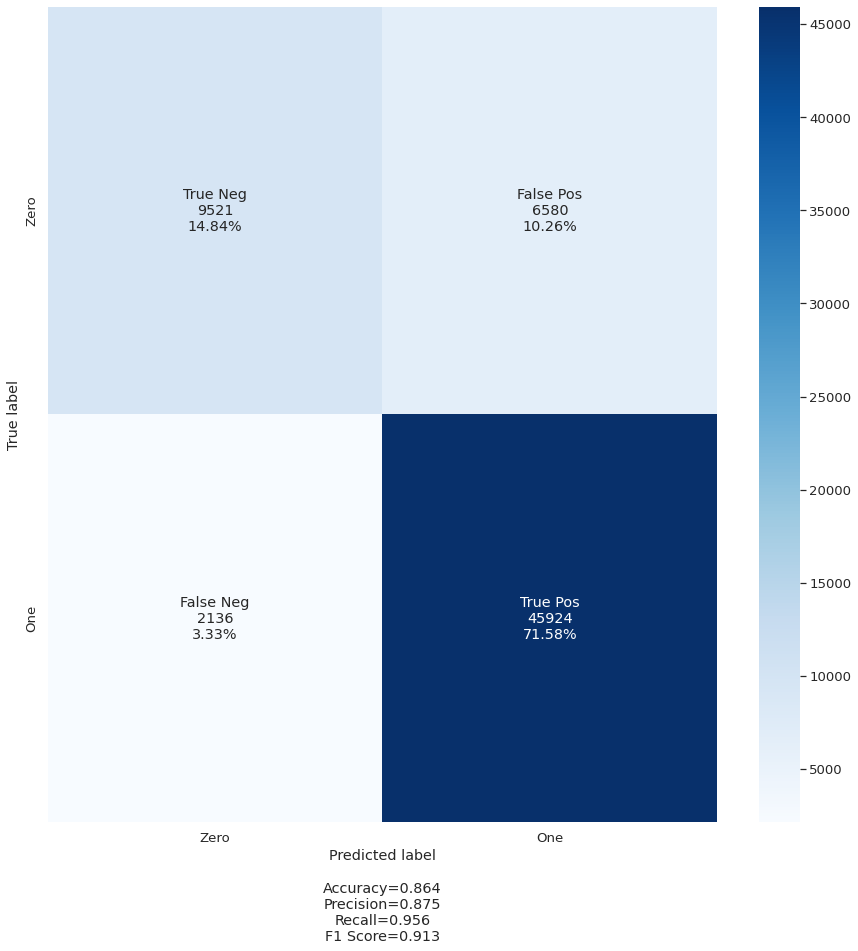

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories)

In [ ]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((149708, 10), (64161, 10), (149708,), (64161,))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
                        random_state=42,
                        min_samples_split=10,
                        splitter='best',             
                        max_depth=7)
       
model2 = decision_tree.fit(X_train, y_train)

In [ ]:
# Predictions
predictions = model2.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions))
cf_matrix_2 = confusion_matrix(y_test, predictions)

The Accuracy of the model is :  0.7531833980143701


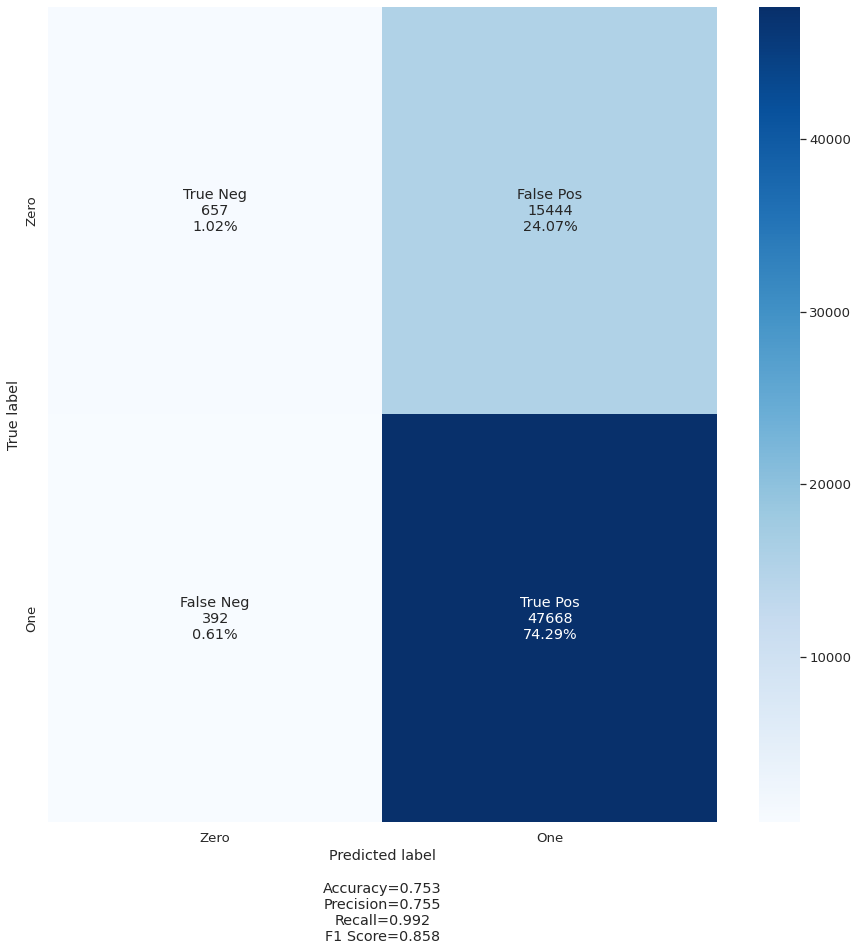

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_2, 
                      group_names=labels,
                      categories=categories)

In [ ]:
from sklearn import svm
support = svm.SVC(kernel='sigmoid',decision_function_shape='ovr')
       
model3 = support.fit(X_train, y_train)

In [ ]:
# Predictions
predictions = model3.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions))
cf_matrix_3 = confusion_matrix(y_test, predictions)

The Accuracy of the model is :  0.641355340471626


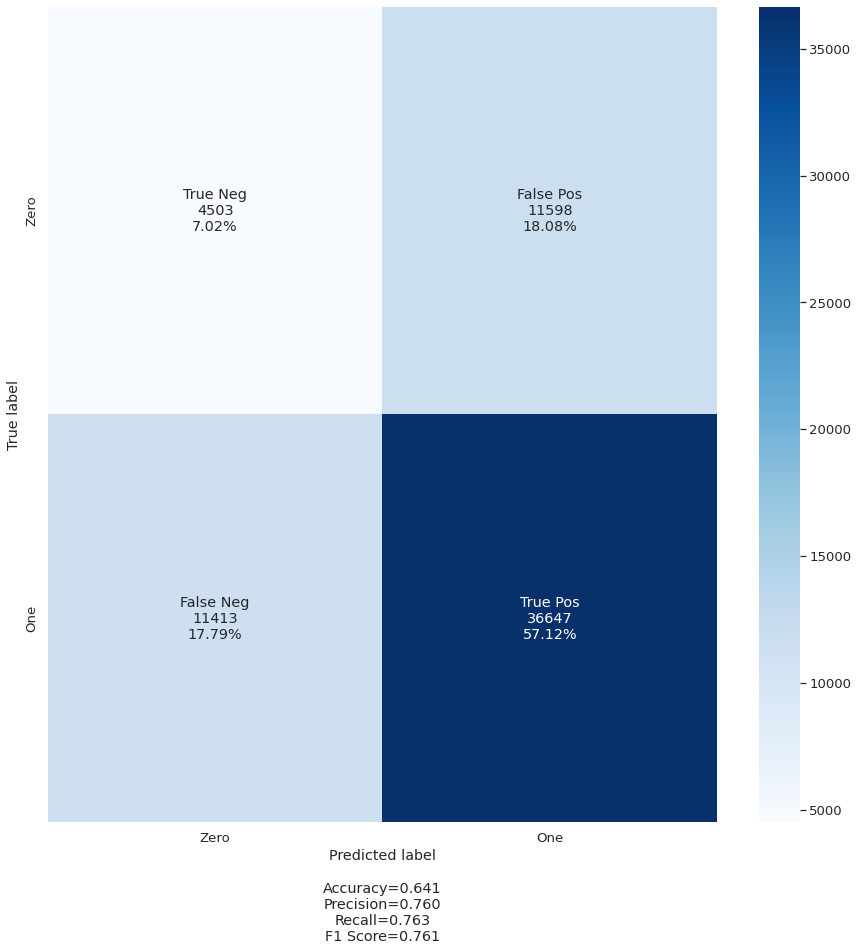

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_3, 
                      group_names=labels,
                      categories=categories)

In [ ]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
model4 = gaussian.fit(X_train, y_train)

In [ ]:
# Predictions
predictions = model4.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions))
cf_matrix_4 = confusion_matrix(y_test, predictions)

The Accuracy of the model is :  0.6915571764779227


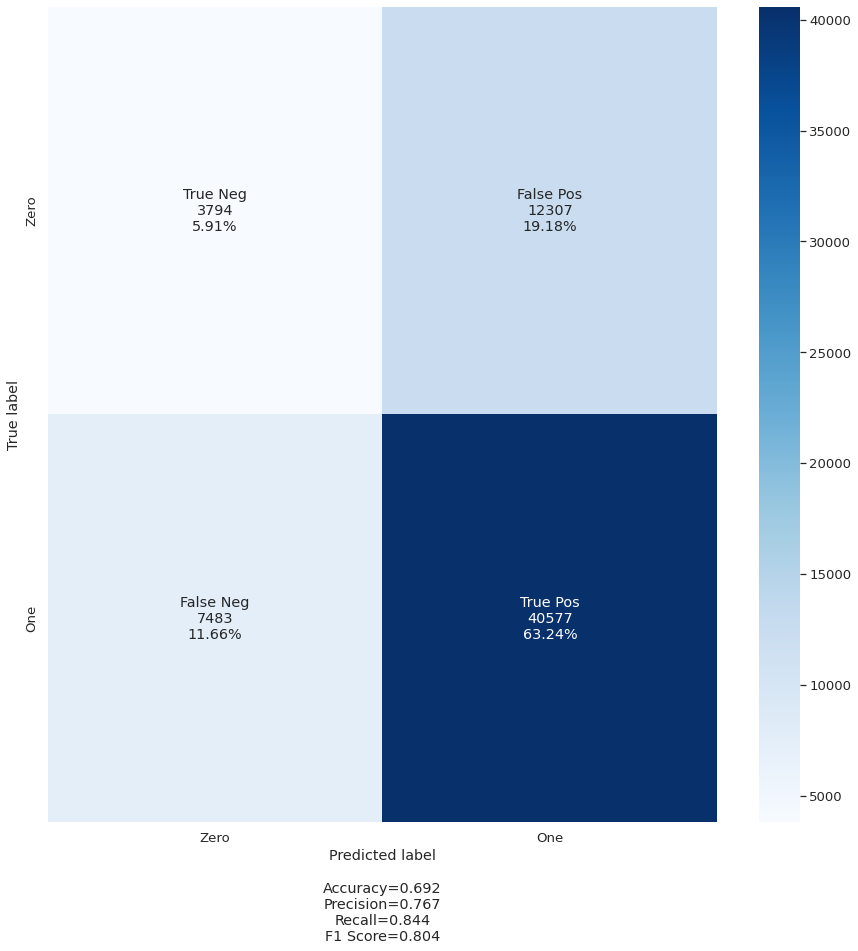

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_4, 
                      group_names=labels,
                      categories=categories)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfclassifier = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
model5 = rfclassifier.fit(X_train, y_train)

In [ ]:
# Predictions
predictions = model5.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions))
cf_matrix_5 = confusion_matrix(y_test, predictions)

The Accuracy of the model is :  0.7557394679010614


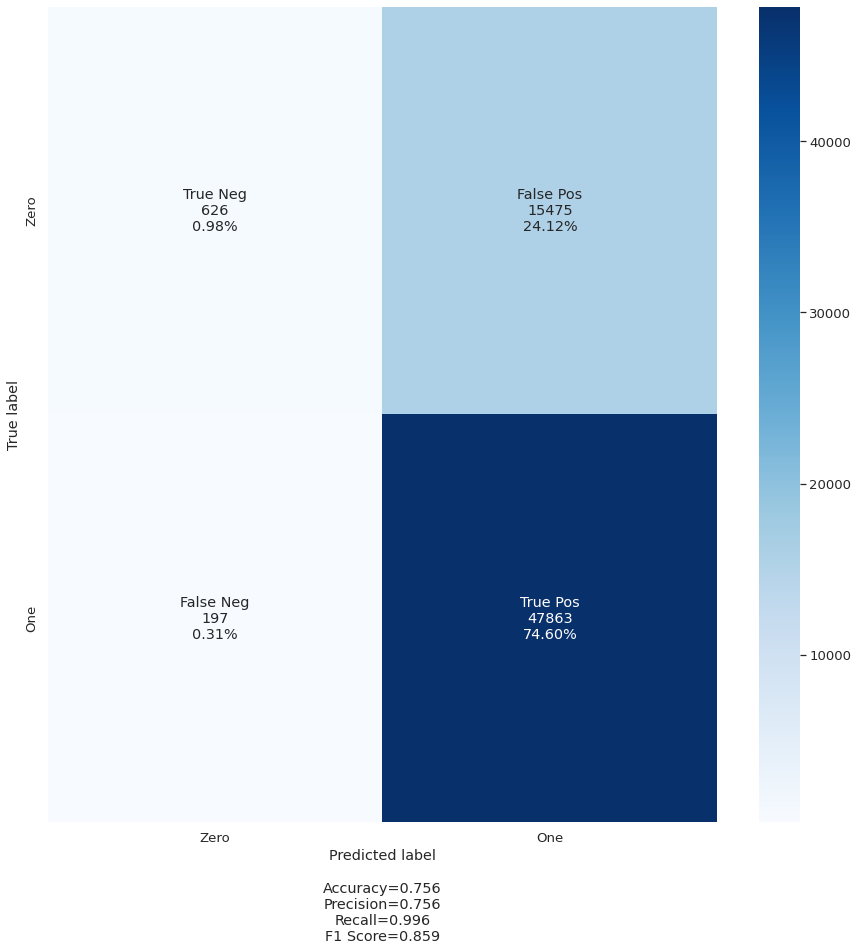

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_5, 
                      group_names=labels,
                      categories=categories)

In [ ]:
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
##pred_prob3 = model3.predict_proba(X_test)
pred_prob4 = model4.predict_proba(X_test)
pred_prob5 = model5.predict_proba(X_test)

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)


# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob4[:,1])
auc_score5 = roc_auc_score(y_test, pred_prob5[:,1])

print(auc_score1, auc_score2, auc_score4, auc_score5)

0.881711439825738 0.6795973686495177 0.6216623196275342 0.7195782924905758


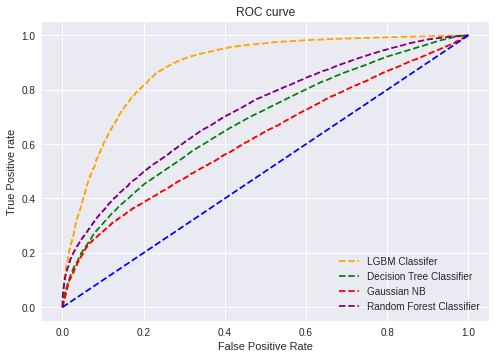

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='LGBM Classifer')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision Tree Classifier')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='Gaussian NB')
plt.plot(fpr5, tpr5, linestyle='--',color='purple', label='Random Forest Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();